<a href="https://colab.research.google.com/github/den2morrow/colab_research/blob/main/data_secret_first_cup_2024_v3_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# @title Install
!pip install lazypredict -q
!pip install optuna xgboost optuna -q
!pip install xgboost-gpu -q  # Установка версии XGBoost с поддержкой GPU

ERROR: Could not find a version that satisfies the requirement xgboost-gpu (from versions: none)
ERROR: No matching distribution found for xgboost-gpu


In [10]:
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from lazypredict.Supervised import LazyClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
train_df = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/train_target.csv')
test_df = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/test.csv')
# example_submit = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/submit.csv')
orders = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/orders.csv')
mobile_events = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/mobile_events.csv')
clients_promo_october = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/clients_promo_october.csv')

In [78]:
train_df.head()

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,25,0
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0
3,000D3A20F23EA95811E7BD373E79565E,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0
4,000D3A20F23EA95811E7BDAE71CD3F33,6,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,30,0


# Preprocess pipeline

In [6]:
######################## Orders #######################################

orders['Discount'] = orders['MenuPrice'] - orders['ProductTotalPrice']

# Количество использованных промо
client_count_promo = orders.groupby('ClientUUId')['apply_promo'].sum().reset_index(name='client_count_promo')

# Количество заказов клиента
client_order_counts = orders.groupby('ClientUUId')['OrderUUId'].count().reset_index(name='client_order_count')

# Средняя сумма заказа клиента
client_avg_order_price = orders.groupby('ClientUUId')['OrderTotalPrice'].mean().reset_index(name='client_avg_order_price')

# События клиента
client_event_counts = mobile_events.groupby('ClientUUId')['EventName'].count().reset_index(name='client_event_count')


# Объединение с новыми признаками
client_order_features = client_count_promo.merge(client_order_counts, on='ClientUUId', how='left')
client_order_features = client_order_features.merge(client_avg_order_price, on='ClientUUId', how='left')
client_order_features = client_order_features.merge(client_event_counts, on='ClientUUId', how='left')

client_order_features['percent_order_with_promo'] = client_order_features['client_count_promo'] / client_order_features['client_order_count']

# Заполнение пустых значений
client_order_features['client_event_count'] = client_order_features['client_event_count'].fillna(0)

######################## Client Promo October #######################################


# Делаю копию, чтобы на ней и создавать новые фичи этой таблицы
promo_features = clients_promo_october.copy()

# Отношение скидки к порогу срабатывания
# promo_features['discount_to_orderprice_ratio'] = promo_features['Discount'] / promo_features['OrderPrice']

# Средний размер скидки для клиента
avg_discount_per_client = promo_features.groupby('ClientUUId')['Discount'].mean().reset_index(name='avg_discount_per_client')
avg_discount_per_client.columns = ['ClientUUId', 'avg_discount_per_client']


# Общее количество промо-акций для клиента
total_promos_per_client = promo_features.groupby('ClientUUId')['Id'].count().reset_index(name='total_promos')

# Скидка по типу заказа
discount_by_order_type = promo_features.groupby('OrderType')['Discount'].mean().reset_index(name='mean_discount_by_type')

# Порог срабатывания по типу заказа
orderprice_by_order_type = promo_features.groupby('OrderType')['OrderPrice'].mean().reset_index(name='mean_orderprice_by_type')


promo_features = avg_discount_per_client.merge(total_promos_per_client, on='ClientUUId', how='left')
# promo_features = promo_features.merge(discount_by_order_type, on='OrderType', how='left')
# promo_features = promo_features.merge(orderprice_by_order_type, on='OrderType', how='left')

promo_features = promo_features[['ClientUUId', 'avg_discount_per_client',
                                 'total_promos']]  # 'mean_discount_by_type', 'mean_orderprice_by_type', 'discount_to_orderprice_ratio'
promo_features.shape

(30000, 3)

In [7]:
################################## Merge Train ####################################################

# Присоединение новых признаков к основному test DataFrame
new_train_df = train_df.merge(client_order_features, on='ClientUUId', how='left')
new_train_df = new_train_df.merge(promo_features, on='ClientUUId', how='left')

# Заполнение пустых значений
new_train_df['client_count_promo'] = new_train_df['client_count_promo'].fillna(0)
new_train_df['client_order_count'] = new_train_df['client_order_count'].fillna(0)
new_train_df['client_avg_order_price'] = new_train_df['client_avg_order_price'].fillna(0)
new_train_df['client_event_count'] = new_train_df['client_event_count'].fillna(0)
new_train_df['percent_order_with_promo'] = new_train_df['percent_order_with_promo'].fillna(0)

# Обработка категориальных признаков
new_train_df = pd.get_dummies(new_train_df, columns=['Id'], prefix='Id')

# Удаление столбцов
X_train_main = new_train_df.drop(columns=['apply_promo', 'OrderType', 'ClientUUId', 'LocalBeginDate', 'LocalEndDate'])  # OrderType пока убираю, так как не знаю, как кодировать его пока, а ClientUUId потому что это id, который и так есть в таблице
y_train_main = new_train_df['apply_promo']


X_train, X_val, y_train, y_val = train_test_split(X_train_main, y_train_main, test_size=0.2, random_state=42, shuffle=True)

In [8]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((22192, 12), (22192,), (5549, 12), (5549,))

In [9]:
############################### Merge Test ########################################################

# Присоединение новых признаков к основному test DataFrame
new_test_df = test_df.merge(client_order_features, on='ClientUUId', how='left')
new_test_df = new_test_df.merge(promo_features, on='ClientUUId', how='left')

# Заполнение пустых значений
new_test_df['client_count_promo'] = new_test_df['client_count_promo'].fillna(0)
new_test_df['client_order_count'] = new_test_df['client_order_count'].fillna(0)
new_test_df['client_avg_order_price'] = new_test_df['client_avg_order_price'].fillna(0)
new_test_df['client_event_count'] = new_test_df['client_event_count'].fillna(0)
new_test_df['percent_order_with_promo'] = new_test_df['percent_order_with_promo'].fillna(0)

# Обработка категориальных признаков
new_test_df = pd.get_dummies(new_test_df, columns=['Id'], prefix='Id')

# Удаление столбцов
X_test = new_test_df.drop(columns=['OrderType', 'ClientUUId', 'LocalBeginDate', 'LocalEndDate'])  # OrderType пока убираю, так как не знаю, как кодировать его пока, а ClientUUId потому что это id, который и так есть в таблице


In [10]:
X_test.head()

,OrderPrice,Discount,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo,avg_discount_per_client,total_promos,Id_5,Id_6,Id_7
0,799,200,2.00,30.00,569.03,107.00,0.07,99.17,12,False,False,True
1,699,200,27.00,58.00,1091.83,267.00,0.47,118.44,16,True,False,False
2,799,20,0.00,0.00,0.00,0.00,0.00,153.57,14,False,True,False
3,799,200,0.00,0.00,0.00,0.00,0.00,145.62,16,True,False,False
4,799,200,11.00,29.00,865.21,74.00,0.38,198.33,18,False,False,True


In [11]:
X_test.shape, X_test.columns

((6806, 12),
 Index(['OrderPrice', 'Discount', 'client_count_promo', 'client_order_count',
        'client_avg_order_price', 'client_event_count',
        'percent_order_with_promo', 'avg_discount_per_client', 'total_promos',
        'Id_5', 'Id_6', 'Id_7'],
       dtype='object'))

In [12]:
# @title Уменьшение major класса

from imblearn.under_sampling import RandomUnderSampler

# Создание экземпляра RandomUnderSampler
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_resampled, y_resampled = rus.fit_resample(X_train_main, y_train_main)

In [28]:
# X_resampled.shape, X_train_main.shape

((1654, 12), (27741, 12))

In [25]:
# @title Увеличение minor класса

# from imblearn.over_sampling import RandomOverSampler

# # Создание экземпляра RandomOverSampler
# ros = RandomOverSampler()

# # Применение увеличения выборки к данным
# X_resampled, y_resampled = ros.fit_resample(X_train_main, y_train_main)

# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, shuffle=True)

In [15]:
# @title SMOTE

# from imblearn.over_sampling import SMOTE

# # Создание экземпляра SMOTE
# smote = SMOTE()

# # Применение SMOTE к данным
# X_resampled, y_resampled = smote.fit_resample(X_train_main, y_train_main)

# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, shuffle=True)

In [16]:
# @title ADASYN

# from imblearn.over_sampling import ADASYN

# # Создание экземпляра ADASYN
# adasyn = ADASYN()

# # Применение ADASYN к данным
# X_resampled, y_resampled = adasyn.fit_resample(X_train_main, y_train_main)

# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, shuffle=True)

In [13]:
# @title Стандартизация данных
# scaler = StandardScaler()
# X_train_resampled_scaled = scaler.fit_transform(X_resampled)
# X_test_scaled = scaler.transform(X_test)

In [48]:
# @title Нормализация данных
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
X_train_resampled_normalize = scaler.fit_transform(X_resampled)
X_test_normalize = scaler.transform(X_test)

In [49]:
# @title Разбиение на train и val
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled_normalize, y_resampled, test_size=0.35, random_state=42, shuffle=True)

# Functions

## ROC AUC CURVE

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def create_roc_auc_curve(model, X, y):
  # Предсказание вероятностей для положительного класса
  y_prob = model.predict_proba(X)[:, 1]

  # Расчет ROC AUC
  roc_auc = roc_auc_score(y, y_prob)
  print('ROC AUC:', roc_auc)

  # Построение ROC кривой
  fpr, tpr, thresholds = roc_curve(y, y_prob)

  plt.figure()
  plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{model.__class__.__name__}')
  plt.legend(loc='lower right')
  plt.show()

## Create csv file

In [19]:
def create_predictions(model, X, save_name: str = 'predictions'):
  # Предсказание вероятностей для положительного класса
  y_prob = model.predict_proba(X)[:, 1]

  # Создание DataFrame с предсказаниями
  predictions = pd.DataFrame({'apply_promo': y_prob})

  # Сохранение предсказаний в CSV файл
  predictions.to_csv(f'{save_name}.csv', index_label='index')

  # Вывод первых строк результата для проверки
  print(predictions.head())
  return predictions

In [20]:
def create_nn_predictions(model, X_tensor, save_name: str = 'predictions'):
  model.eval()
  with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy()

    # Создание DataFrame с предсказаниями
    predictions = pd.DataFrame({'apply_promo': y_pred.flatten()})

    # Сохранение предсказаний в CSV файл
    predictions.to_csv(f'{save_name}.csv', index_label='index')

    return predictions

# Models Check

## Neural Network v1

In [ ]:
################### Шаги работы #############################
# 1. Подготовка данных (включая нормализацию/стандартизацию).
# 2. Определение архитектуры нейросети.
# 3. Определение функции потерь и оптимизатора.
# 4. Обучение модели.
# 5. Оценка модели.

### Подготовка данных к модели

In [57]:
# Проверка наличия устройства CUDA (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# Нормализация данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

In [58]:
# Преобразование обучающих данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device) # Convert to float32 before tensor conversion
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

# Преобразование тестовых данных в тензоры
X_test_tensor = torch.tensor(X_test_normalize, dtype=torch.float32).to(device)

In [59]:
# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Архитектура модели

In [68]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 328)
        self.fc2 = nn.Linear(328, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc5(x))
        return x

# Определение модели
input_dim = X_train.shape[1]
nn_model = BinaryClassificationModel(input_dim).to(device)

# Функция потерь и оптимизатор
criterion = nn.BCELoss()  # nn.CrossEntropyLoss()   nn.BCELossWithLogits()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

In [69]:
num_epochs = 165

for epoch in tqdm(range(num_epochs)):
    nn_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  1%|          | 1/165 [00:00<01:26,  1.89it/s]

Epoch [1/165], Loss: 0.6797


  1%|          | 2/165 [00:00<01:03,  2.55it/s]

Epoch [2/165], Loss: 0.6770


  2%|▏         | 3/165 [00:01<00:54,  2.96it/s]

Epoch [3/165], Loss: 0.7270


  2%|▏         | 4/165 [00:01<00:49,  3.27it/s]

Epoch [4/165], Loss: 0.6929


  3%|▎         | 5/165 [00:01<00:47,  3.34it/s]

Epoch [5/165], Loss: 0.6962


  4%|▎         | 6/165 [00:01<00:46,  3.39it/s]

Epoch [6/165], Loss: 0.6928


  4%|▍         | 7/165 [00:02<00:44,  3.53it/s]

Epoch [7/165], Loss: 0.6176


  5%|▍         | 8/165 [00:02<00:43,  3.62it/s]

Epoch [8/165], Loss: 0.5937


  5%|▌         | 9/165 [00:02<00:43,  3.57it/s]

Epoch [9/165], Loss: 0.7357


  6%|▌         | 10/165 [00:03<00:42,  3.62it/s]

Epoch [10/165], Loss: 1.1564


  7%|▋         | 11/165 [00:03<00:44,  3.50it/s]

Epoch [11/165], Loss: 0.3787


  7%|▋         | 12/165 [00:03<00:45,  3.37it/s]

Epoch [12/165], Loss: 0.6917


  8%|▊         | 13/165 [00:03<00:47,  3.20it/s]

Epoch [13/165], Loss: 0.7284


  8%|▊         | 14/165 [00:04<00:48,  3.14it/s]

Epoch [14/165], Loss: 0.5109


  9%|▉         | 15/165 [00:04<00:48,  3.11it/s]

Epoch [15/165], Loss: 0.7764


 10%|▉         | 16/165 [00:05<00:49,  2.99it/s]

Epoch [16/165], Loss: 0.8358


 10%|█         | 17/165 [00:05<00:49,  2.99it/s]

Epoch [17/165], Loss: 0.7492


 11%|█         | 18/165 [00:05<00:50,  2.93it/s]

Epoch [18/165], Loss: 1.0791


 12%|█▏        | 19/165 [00:06<00:50,  2.88it/s]

Epoch [19/165], Loss: 0.6032


 12%|█▏        | 20/165 [00:06<00:50,  2.86it/s]

Epoch [20/165], Loss: 0.6247


 13%|█▎        | 21/165 [00:06<00:50,  2.84it/s]

Epoch [21/165], Loss: 0.5856


 13%|█▎        | 22/165 [00:07<00:50,  2.86it/s]

Epoch [22/165], Loss: 0.5265


 14%|█▍        | 23/165 [00:07<00:49,  2.87it/s]

Epoch [23/165], Loss: 0.6265


 15%|█▍        | 24/165 [00:07<00:50,  2.81it/s]

Epoch [24/165], Loss: 0.8392


 15%|█▌        | 25/165 [00:08<00:49,  2.82it/s]

Epoch [25/165], Loss: 0.7424


 16%|█▌        | 26/165 [00:08<00:49,  2.79it/s]

Epoch [26/165], Loss: 0.8171


 16%|█▋        | 27/165 [00:08<00:50,  2.73it/s]

Epoch [27/165], Loss: 0.5272


 17%|█▋        | 28/165 [00:09<00:49,  2.76it/s]

Epoch [28/165], Loss: 0.6310


 18%|█▊        | 29/165 [00:09<00:49,  2.75it/s]

Epoch [29/165], Loss: 0.6975


 18%|█▊        | 30/165 [00:10<00:49,  2.73it/s]

Epoch [30/165], Loss: 0.7175


 19%|█▉        | 31/165 [00:10<00:49,  2.69it/s]

Epoch [31/165], Loss: 0.7345


 19%|█▉        | 32/165 [00:10<00:55,  2.38it/s]

Epoch [32/165], Loss: 0.4873


 20%|██        | 33/165 [00:11<00:57,  2.29it/s]

Epoch [33/165], Loss: 0.5062


 21%|██        | 34/165 [00:11<00:58,  2.22it/s]

Epoch [34/165], Loss: 0.5034


 21%|██        | 35/165 [00:12<01:00,  2.16it/s]

Epoch [35/165], Loss: 0.7463


 22%|██▏       | 36/165 [00:12<01:00,  2.13it/s]

Epoch [36/165], Loss: 0.7182


 22%|██▏       | 37/165 [00:13<01:02,  2.04it/s]

Epoch [37/165], Loss: 0.4386


 23%|██▎       | 38/165 [00:13<01:04,  1.96it/s]

Epoch [38/165], Loss: 0.4643


 24%|██▎       | 39/165 [00:14<01:05,  1.92it/s]

Epoch [39/165], Loss: 0.6276


 24%|██▍       | 40/165 [00:15<01:09,  1.80it/s]

Epoch [40/165], Loss: 0.6788


 25%|██▍       | 41/165 [00:15<01:10,  1.76it/s]

Epoch [41/165], Loss: 0.6536


 25%|██▌       | 42/165 [00:16<01:08,  1.78it/s]

Epoch [42/165], Loss: 0.5425


 26%|██▌       | 43/165 [00:16<01:05,  1.87it/s]

Epoch [43/165], Loss: 0.5927


 27%|██▋       | 44/165 [00:17<01:03,  1.91it/s]

Epoch [44/165], Loss: 0.6906


 27%|██▋       | 45/165 [00:17<01:01,  1.95it/s]

Epoch [45/165], Loss: 0.6437


 28%|██▊       | 46/165 [00:18<01:01,  1.93it/s]

Epoch [46/165], Loss: 0.6083


 28%|██▊       | 47/165 [00:18<01:02,  1.89it/s]

Epoch [47/165], Loss: 0.5321


 29%|██▉       | 48/165 [00:19<01:01,  1.91it/s]

Epoch [48/165], Loss: 0.7817


 30%|██▉       | 49/165 [00:19<01:02,  1.86it/s]

Epoch [49/165], Loss: 0.5075


 30%|███       | 50/165 [00:20<00:55,  2.06it/s]

Epoch [50/165], Loss: 0.5100


 31%|███       | 51/165 [00:20<00:52,  2.19it/s]

Epoch [51/165], Loss: 0.6822


 32%|███▏      | 52/165 [00:21<00:48,  2.31it/s]

Epoch [52/165], Loss: 0.5811


 32%|███▏      | 53/165 [00:21<00:46,  2.40it/s]

Epoch [53/165], Loss: 1.0062


 33%|███▎      | 54/165 [00:21<00:45,  2.45it/s]

Epoch [54/165], Loss: 0.5374


 33%|███▎      | 55/165 [00:22<00:43,  2.52it/s]

Epoch [55/165], Loss: 0.6111


 34%|███▍      | 56/165 [00:22<00:42,  2.57it/s]

Epoch [56/165], Loss: 0.3701


 35%|███▍      | 57/165 [00:22<00:41,  2.58it/s]

Epoch [57/165], Loss: 0.9124


 35%|███▌      | 58/165 [00:23<00:40,  2.66it/s]

Epoch [58/165], Loss: 0.6607


 36%|███▌      | 59/165 [00:23<00:40,  2.61it/s]

Epoch [59/165], Loss: 0.7067


 36%|███▋      | 60/165 [00:24<00:40,  2.58it/s]

Epoch [60/165], Loss: 1.0624


 37%|███▋      | 61/165 [00:24<00:39,  2.63it/s]

Epoch [61/165], Loss: 0.6369


 38%|███▊      | 62/165 [00:24<00:39,  2.61it/s]

Epoch [62/165], Loss: 0.3701


 38%|███▊      | 63/165 [00:25<00:38,  2.67it/s]

Epoch [63/165], Loss: 0.7203


 39%|███▉      | 64/165 [00:25<00:37,  2.70it/s]

Epoch [64/165], Loss: 0.6008


 39%|███▉      | 65/165 [00:25<00:37,  2.66it/s]

Epoch [65/165], Loss: 0.7811


 40%|████      | 66/165 [00:26<00:38,  2.58it/s]

Epoch [66/165], Loss: 0.7224


 41%|████      | 67/165 [00:26<00:41,  2.34it/s]

Epoch [67/165], Loss: 0.2084


 41%|████      | 68/165 [00:27<00:43,  2.25it/s]

Epoch [68/165], Loss: 0.4243


 42%|████▏     | 69/165 [00:27<00:44,  2.14it/s]

Epoch [69/165], Loss: 0.3078


 42%|████▏     | 70/165 [00:28<00:45,  2.09it/s]

Epoch [70/165], Loss: 0.7590


 43%|████▎     | 71/165 [00:28<00:46,  2.03it/s]

Epoch [71/165], Loss: 0.6972


 44%|████▎     | 72/165 [00:29<00:46,  1.98it/s]

Epoch [72/165], Loss: 0.5467


 44%|████▍     | 73/165 [00:30<00:47,  1.92it/s]

Epoch [73/165], Loss: 0.7571


 45%|████▍     | 74/165 [00:30<00:48,  1.89it/s]

Epoch [74/165], Loss: 0.5759


 45%|████▌     | 75/165 [00:30<00:44,  2.03it/s]

Epoch [75/165], Loss: 0.7414


 46%|████▌     | 76/165 [00:31<00:40,  2.20it/s]

Epoch [76/165], Loss: 0.7210


 47%|████▋     | 77/165 [00:31<00:37,  2.32it/s]

Epoch [77/165], Loss: 0.5245


 47%|████▋     | 78/165 [00:32<00:36,  2.40it/s]

Epoch [78/165], Loss: 0.4497


 48%|████▊     | 79/165 [00:32<00:34,  2.49it/s]

Epoch [79/165], Loss: 0.9237


 48%|████▊     | 80/165 [00:32<00:33,  2.51it/s]

Epoch [80/165], Loss: 0.5807


 49%|████▉     | 81/165 [00:33<00:32,  2.56it/s]

Epoch [81/165], Loss: 0.5090


 50%|████▉     | 82/165 [00:33<00:31,  2.61it/s]

Epoch [82/165], Loss: 0.4720


 50%|█████     | 83/165 [00:33<00:31,  2.61it/s]

Epoch [83/165], Loss: 0.4319


 51%|█████     | 84/165 [00:34<00:31,  2.61it/s]

Epoch [84/165], Loss: 0.6514


 52%|█████▏    | 85/165 [00:34<00:30,  2.60it/s]

Epoch [85/165], Loss: 0.5423


 52%|█████▏    | 86/165 [00:35<00:50,  1.56it/s]

Epoch [86/165], Loss: 0.5491


 53%|█████▎    | 87/165 [00:36<00:43,  1.78it/s]

Epoch [87/165], Loss: 0.8545


 53%|█████▎    | 88/165 [00:36<00:38,  1.98it/s]

Epoch [88/165], Loss: 0.7193


 54%|█████▍    | 89/165 [00:37<00:35,  2.16it/s]

Epoch [89/165], Loss: 0.6827


 55%|█████▍    | 90/165 [00:37<00:32,  2.28it/s]

Epoch [90/165], Loss: 0.4571


 55%|█████▌    | 91/165 [00:37<00:31,  2.38it/s]

Epoch [91/165], Loss: 0.4114


 56%|█████▌    | 92/165 [00:38<00:30,  2.43it/s]

Epoch [92/165], Loss: 0.5229


 56%|█████▋    | 93/165 [00:38<00:28,  2.50it/s]

Epoch [93/165], Loss: 0.5417


 57%|█████▋    | 94/165 [00:39<00:28,  2.52it/s]

Epoch [94/165], Loss: 0.4621


 58%|█████▊    | 95/165 [00:39<00:27,  2.56it/s]

Epoch [95/165], Loss: 0.8515


 58%|█████▊    | 96/165 [00:39<00:26,  2.58it/s]

Epoch [96/165], Loss: 0.8060


 59%|█████▉    | 97/165 [00:40<00:25,  2.62it/s]

Epoch [97/165], Loss: 0.5354


 59%|█████▉    | 98/165 [00:40<00:25,  2.62it/s]

Epoch [98/165], Loss: 0.7343


 60%|██████    | 99/165 [00:41<00:27,  2.36it/s]

Epoch [99/165], Loss: 0.3546


 61%|██████    | 100/165 [00:41<00:29,  2.24it/s]

Epoch [100/165], Loss: 0.3897


 61%|██████    | 101/165 [00:42<00:29,  2.18it/s]

Epoch [101/165], Loss: 0.4625


 62%|██████▏   | 102/165 [00:42<00:30,  2.10it/s]

Epoch [102/165], Loss: 0.4706


 62%|██████▏   | 103/165 [00:43<00:30,  2.06it/s]

Epoch [103/165], Loss: 0.4367


 63%|██████▎   | 104/165 [00:43<00:30,  1.98it/s]

Epoch [104/165], Loss: 0.5947


 64%|██████▎   | 105/165 [00:44<00:30,  1.95it/s]

Epoch [105/165], Loss: 0.6819


 64%|██████▍   | 106/165 [00:44<00:30,  1.92it/s]

Epoch [106/165], Loss: 0.8238


 65%|██████▍   | 107/165 [00:45<00:30,  1.91it/s]

Epoch [107/165], Loss: 0.5021


 65%|██████▌   | 108/165 [00:45<00:28,  2.02it/s]

Epoch [108/165], Loss: 0.3636


 66%|██████▌   | 109/165 [00:46<00:26,  2.15it/s]

Epoch [109/165], Loss: 0.4116


 67%|██████▋   | 110/165 [00:46<00:24,  2.28it/s]

Epoch [110/165], Loss: 0.3564


 67%|██████▋   | 111/165 [00:46<00:22,  2.35it/s]

Epoch [111/165], Loss: 0.5230


 68%|██████▊   | 112/165 [00:47<00:21,  2.44it/s]

Epoch [112/165], Loss: 0.7178


 68%|██████▊   | 113/165 [00:47<00:20,  2.51it/s]

Epoch [113/165], Loss: 0.4183


 69%|██████▉   | 114/165 [00:47<00:20,  2.49it/s]

Epoch [114/165], Loss: 0.6701


 70%|██████▉   | 115/165 [00:48<00:19,  2.55it/s]

Epoch [115/165], Loss: 0.8004


 70%|███████   | 116/165 [00:48<00:19,  2.56it/s]

Epoch [116/165], Loss: 0.8236


 71%|███████   | 117/165 [00:49<00:18,  2.60it/s]

Epoch [117/165], Loss: 0.6144


 72%|███████▏  | 118/165 [00:49<00:17,  2.64it/s]

Epoch [118/165], Loss: 1.0269


 72%|███████▏  | 119/165 [00:49<00:17,  2.61it/s]

Epoch [119/165], Loss: 0.6451


 73%|███████▎  | 120/165 [00:50<00:16,  2.65it/s]

Epoch [120/165], Loss: 0.6887


 73%|███████▎  | 121/165 [00:50<00:16,  2.67it/s]

Epoch [121/165], Loss: 0.6482


 74%|███████▍  | 122/165 [00:50<00:16,  2.58it/s]

Epoch [122/165], Loss: 0.2034


 75%|███████▍  | 123/165 [00:51<00:16,  2.62it/s]

Epoch [123/165], Loss: 0.8362


 75%|███████▌  | 124/165 [00:51<00:15,  2.60it/s]

Epoch [124/165], Loss: 0.1335


 76%|███████▌  | 125/165 [00:52<00:15,  2.61it/s]

Epoch [125/165], Loss: 0.4441


 76%|███████▋  | 126/165 [00:52<00:14,  2.63it/s]

Epoch [126/165], Loss: 0.5532


 77%|███████▋  | 127/165 [00:52<00:14,  2.61it/s]

Epoch [127/165], Loss: 0.7062


 78%|███████▊  | 128/165 [00:53<00:13,  2.66it/s]

Epoch [128/165], Loss: 0.8150


 78%|███████▊  | 129/165 [00:53<00:13,  2.68it/s]

Epoch [129/165], Loss: 0.7679


 79%|███████▉  | 130/165 [00:54<00:13,  2.58it/s]

Epoch [130/165], Loss: 0.3157


 79%|███████▉  | 131/165 [00:54<00:12,  2.62it/s]

Epoch [131/165], Loss: 0.9553


 80%|████████  | 132/165 [00:54<00:12,  2.59it/s]

Epoch [132/165], Loss: 0.5974


 81%|████████  | 133/165 [00:55<00:12,  2.61it/s]

Epoch [133/165], Loss: 0.3196


 81%|████████  | 134/165 [00:55<00:12,  2.48it/s]

Epoch [134/165], Loss: 0.4618


 82%|████████▏ | 135/165 [00:56<00:13,  2.29it/s]

Epoch [135/165], Loss: 0.8738


 82%|████████▏ | 136/165 [00:56<00:13,  2.22it/s]

Epoch [136/165], Loss: 0.7761


 83%|████████▎ | 137/165 [00:57<00:13,  2.12it/s]

Epoch [137/165], Loss: 0.3863


 84%|████████▎ | 138/165 [00:57<00:13,  2.05it/s]

Epoch [138/165], Loss: 0.6545


 84%|████████▍ | 139/165 [00:58<00:13,  1.97it/s]

Epoch [139/165], Loss: 0.4770


 85%|████████▍ | 140/165 [00:58<00:13,  1.92it/s]

Epoch [140/165], Loss: 0.6675


 85%|████████▌ | 141/165 [00:59<00:12,  1.90it/s]

Epoch [141/165], Loss: 0.5047


 86%|████████▌ | 142/165 [00:59<00:12,  1.88it/s]

Epoch [142/165], Loss: 0.9465


 87%|████████▋ | 143/165 [01:00<00:11,  1.93it/s]

Epoch [143/165], Loss: 1.2142


 87%|████████▋ | 144/165 [01:00<00:10,  2.08it/s]

Epoch [144/165], Loss: 0.6901


 88%|████████▊ | 145/165 [01:01<00:08,  2.22it/s]

Epoch [145/165], Loss: 0.5533


 88%|████████▊ | 146/165 [01:01<00:08,  2.29it/s]

Epoch [146/165], Loss: 0.4259


 89%|████████▉ | 147/165 [01:01<00:07,  2.36it/s]

Epoch [147/165], Loss: 0.5478


 90%|████████▉ | 148/165 [01:02<00:07,  2.41it/s]

Epoch [148/165], Loss: 0.5038


 90%|█████████ | 149/165 [01:02<00:06,  2.44it/s]

Epoch [149/165], Loss: 0.2578


 91%|█████████ | 150/165 [01:03<00:06,  2.49it/s]

Epoch [150/165], Loss: 0.4753


 92%|█████████▏| 151/165 [01:03<00:05,  2.52it/s]

Epoch [151/165], Loss: 0.6902


 92%|█████████▏| 152/165 [01:03<00:05,  2.52it/s]

Epoch [152/165], Loss: 0.5934


 93%|█████████▎| 153/165 [01:04<00:04,  2.56it/s]

Epoch [153/165], Loss: 0.9153


 93%|█████████▎| 154/165 [01:04<00:04,  2.57it/s]

Epoch [154/165], Loss: 0.6289


 94%|█████████▍| 155/165 [01:05<00:03,  2.59it/s]

Epoch [155/165], Loss: 0.4968


 95%|█████████▍| 156/165 [01:05<00:03,  2.60it/s]

Epoch [156/165], Loss: 0.4845


 95%|█████████▌| 157/165 [01:05<00:03,  2.60it/s]

Epoch [157/165], Loss: 0.5341


 96%|█████████▌| 158/165 [01:06<00:02,  2.63it/s]

Epoch [158/165], Loss: 0.5533


 96%|█████████▋| 159/165 [01:06<00:02,  2.63it/s]

Epoch [159/165], Loss: 0.4223


 97%|█████████▋| 160/165 [01:06<00:01,  2.62it/s]

Epoch [160/165], Loss: 1.3228


 98%|█████████▊| 161/165 [01:07<00:01,  2.64it/s]

Epoch [161/165], Loss: 0.7757


 98%|█████████▊| 162/165 [01:07<00:01,  2.60it/s]

Epoch [162/165], Loss: 0.5038


 99%|█████████▉| 163/165 [01:08<00:00,  2.61it/s]

Epoch [163/165], Loss: 0.7617


 99%|█████████▉| 164/165 [01:08<00:00,  2.64it/s]

Epoch [164/165], Loss: 1.0906


100%|██████████| 165/165 [01:08<00:00,  2.40it/s]

Epoch [165/165], Loss: 0.4645


In [70]:
nn_model.eval()
with torch.no_grad():
    y_pred_train = nn_model(X_train_tensor).numpy()
    y_pred_val = nn_model(X_val_tensor).numpy()

    # Преобразование предсказаний в бинарные значения
    y_pred_train_int = (y_pred_train > 0.5).astype(int)
    y_pred_val_int = (y_pred_val > 0.5).astype(int)

    # Вычисление метрик
    from sklearn.metrics import accuracy_score, roc_auc_score

    train_accuracy = accuracy_score(y_train, y_pred_train_int)
    val_accuracy = accuracy_score(y_val, y_pred_val_int)
    val_roc_auc = roc_auc_score(y_val, y_pred_val)

    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Accuracy: {val_accuracy:.4f}')
    print(f'Val ROC AUC: {val_roc_auc:.4f}')

Train Accuracy: 0.7079
Val Accuracy: 0.6788
Val ROC AUC: 0.7064


In [71]:
create_nn_predictions(model=nn_model, X_tensor=X_test_tensor, save_name='prediction_nn_v4')

,apply_promo
0,0.31
1,0.69
2,0.41
3,0.38
4,0.54
...,...
6801,0.30
6802,0.41
6803,0.42
6804,0.70


## XGBoost with Optuna


In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0)
    }

    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], early_stopping_rounds=10, verbose=False)

    y_prob = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_prob)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print('Best Parameters for XGBClassifier:', best_params)
# {'n_estimators': 197, 'learning_rate': 0.13191888119631004, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9872398113489511, 'colsample_bytree': 0.9153113322066548}

# Обучение модели с лучшими параметрами
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

[I 2024-07-23 06:50:52,318] A new study created in memory with name: no-name-131cbb4d-209f-4c3d-9a60-eb184e6e17be
[I 2024-07-23 06:50:52,502] Trial 0 finished with value: 0.7274230126521843 and parameters: {'n_estimators': 134, 'learning_rate': 0.0671532718570651, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9272988294815663, 'colsample_bytree': 0.8980376910176554}. Best is trial 0 with value: 0.7274230126521843.
[I 2024-07-23 06:50:52,623] Trial 1 finished with value: 0.7205538314633564 and parameters: {'n_estimators': 146, 'learning_rate': 0.17147592638732478, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9188873627686853, 'colsample_bytree': 0.892175764552827}. Best is trial 0 with value: 0.7274230126521843.
[I 2024-07-23 06:50:52,732] Trial 2 finished with value: 0.7187992360945333 and parameters: {'n_estimators': 118, 'learning_rate': 0.06211510037896948, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8681575203272882, 'colsample_bytree': 0.9231295402833861

Best Parameters for XGBClassifier: {'n_estimators': 197, 'learning_rate': 0.13191888119631004, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9872398113489511, 'colsample_bytree': 0.9153113322066548}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9153113322066548, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13191888119631004,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=197, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

ROC AUC: 0.9929260305459782


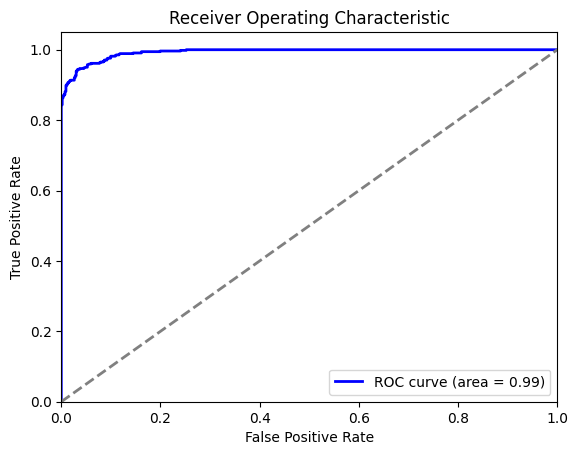

ROC AUC: 0.7454702793029362


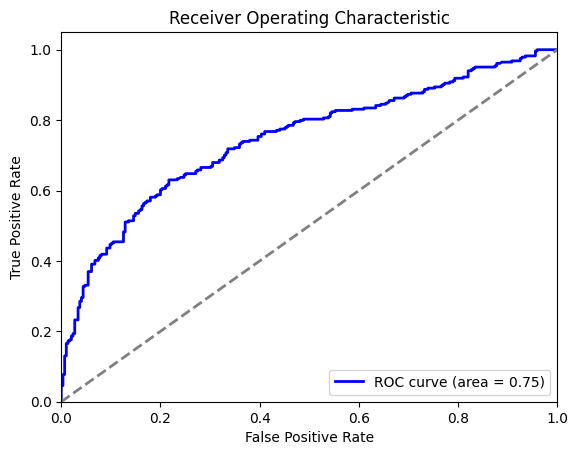

   apply_promo
0         0.11
1         0.93
2         0.70
3         0.27
4         0.68


,apply_promo
0,0.11
1,0.93
2,0.70
3,0.27
4,0.68
...,...
6801,0.06
6802,0.09
6803,0.14
6804,0.90


In [ ]:
create_roc_auc_curve(best_xgb_model, X_train, y_train)
create_roc_auc_curve(best_xgb_model, X_val, y_val)
create_predictions(best_xgb_model, X_test, save_name='predictions_xgb_optuna_v2')

## XGBoost with GPU

In [ ]:
# Create an XGBoost classifier object with GPU support
xgb_model = xgb.XGBClassifier() #tree_method='gpu_hist')

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0.1, 0.3, 0.5],
    'alpha': [0.1, 0.3, 0.5],
    'lambda': [0.1, 0.3, 0.5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print(grid_search.best_params_)
# Fitting 3 folds for each of 17496 candidates, totalling 52488 fits
# {'alpha': 0.3, 'colsample_bytree': 0.7, 'gamma': 0.1, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}

# Get the best model
best_xgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 17496 candidates, totalling 52488 fits
{'alpha': 0.3, 'colsample_bytree': 0.7, 'gamma': 0.1, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}


ROC AUC: 0.8658057436408702


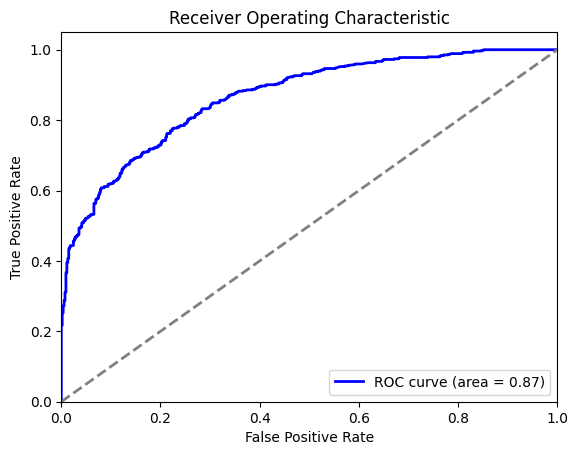

ROC AUC: 0.7471532585342563


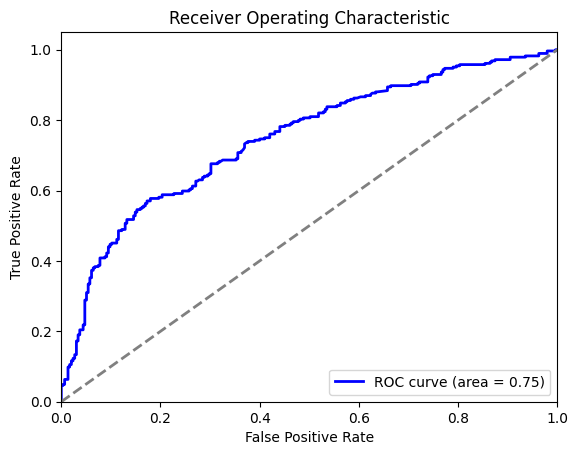

   apply_promo
0         0.45
1         0.71
2         0.47
3         0.43
4         0.59


,apply_promo
0,0.45
1,0.71
2,0.47
3,0.43
4,0.59
...,...
6801,0.32
6802,0.44
6803,0.36
6804,0.71


In [ ]:
create_roc_auc_curve(best_xgb_model, X_train, y_train)
create_roc_auc_curve(best_xgb_model, X_val, y_val)
create_predictions(best_xgb_model, X_test, save_name='predictions_xgb_gpu_v1')

## Random Forest Classificator with GridSearch

In [55]:
# @title Find the best params for Random Forest Classification with GridSearch

from sklearn.model_selection import GridSearchCV

# Определение параметров для Grid Search
param_grid = {
    'max_depth': [1, 3, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': list(range(1, 100)),
}

# Создание модели RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Настройка Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# Обучение Grid Search
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_
print('Best Parameters:', best_params)
# Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 81}
# {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
# {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

# # Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 891 candidates, totalling 4455 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 81}


ROC AUC: 0.8519918580982844


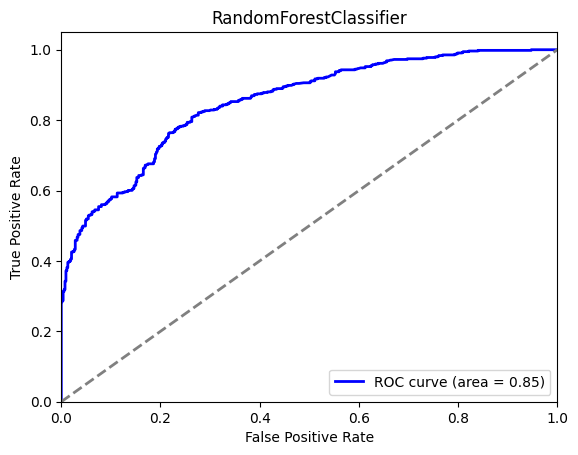

ROC AUC: 0.7423012652184292


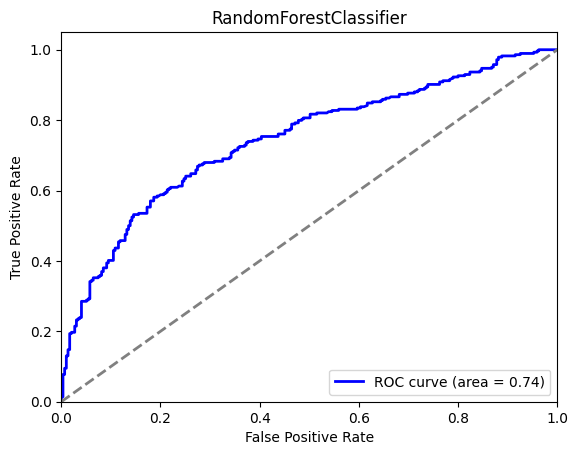

   apply_promo
0         0.34
1         0.75
2         0.39
3         0.35
4         0.70


,apply_promo
0,0.34
1,0.75
2,0.39
3,0.35
4,0.70
...,...
6801,0.17
6802,0.39
6803,0.33
6804,0.80


In [56]:
create_roc_auc_curve(best_model, X_train, y_train)
create_roc_auc_curve(best_model, X_val, y_val)

create_predictions(best_model, X_test, save_name='predictions_rf_grid_search_new_v2')

In [ ]:
# @title Find the best RandomForestClassifier with RandomizedSearchCV

# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Define the parameter distributions to sample from
# param_dist = {
#     'n_estimators': randint(50, 200),
#     'max_depth': randint(5, 20),
#     'min_samples_split': randint(2, 10),
#     'min_samples_leaf': randint(1, 5),
#     'max_features': ['auto', 'sqrt', 'log2', None],
#     'bootstrap': [True, False],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# # Create a Random Forest Classifier
# rf = RandomForestClassifier()

# # Use RandomizedSearchCV to find the best parameters
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
# random_search.fit(X_train, y_train)

# # Print the best parameters and score
# print("Best parameters found: ", random_search.best_params_)
# print("Best ROC AUC score: ", random_search.best_score_)
#Under sampling
#Fitting 5 folds for each of 50 candidates, totalling 250 fits
#Best parameters found:  {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 197}
#Best ROC AUC score:  0.7647584011825781

#Over sampling
#Fitting 5 folds for each of 50 candidates, totalling 250 fits
#Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
#Best ROC AUC score:  0.9991443595015946

#SMOTE
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
# Best ROC AUC score:  0.9849712864880035

#Adasyn
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
# Best ROC AUC score:  0.9853975200237596

# Get the best model
# best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
Best ROC AUC score:  0.9853975200237596


In [ ]:
# create_predictions(best_rf_model, X_test, save_name='predictions_rf_grid_search_with_adasyn')

In [ ]:
# create_roc_auc_curve(best_rf_model, X_train, y_train)
# create_roc_auc_curve(best_rf_model, X_val, y_val)

In [ ]:
X_train.columns, X_test.columns

(Index(['OrderPrice', 'Discount', 'client_count_promo', 'client_order_count',
        'client_avg_order_price', 'client_event_count',
        'percent_order_with_promo', 'avg_discount_per_client', 'total_promos',
        'Id_5', 'Id_6', 'Id_7'],
       dtype='object'),
 Index(['OrderPrice', 'Discount', 'client_count_promo', 'client_order_count',
        'client_avg_order_price', 'client_event_count',
        'percent_order_with_promo', 'avg_discount_per_client', 'total_promos',
        'Id_5', 'Id_6', 'Id_7'],
       dtype='object'))

In [ ]:
X_resampled.shape, y_resampled.shape

((53753, 12), (53753,))

Делаю under sampling (так как модель с ним показала лучшие результаты), а потом просто делаю ансамбль из моделей, либо более лучшую модель, чтобы получить лучший результат.

In [ ]:
#Under sampling
#Fitting 5 folds for each of 50 candidates, totalling 250 fits
#Best parameters found:  {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 197}
#Best ROC AUC score:  0.7647584011825781

#Over sampling
#Fitting 5 folds for each of 50 candidates, totalling 250 fits
#Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
#Best ROC AUC score:  0.9991443595015946

#SMOTE
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
# Best ROC AUC score:  0.9849712864880035

#Adasyn
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 63}
# Best ROC AUC score:  0.9853975200237596


# {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
# {'bootstrap': False, 'max_depth': None, 'min_samples_split': 5}
# {'bootstrap': True, 'max_depth': None, 'min_samples_split': 5}
# {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

In [ ]:
# Получение весов классов
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_main), y=y_train_main)

# Создание модели RandomForestClassifier с лучшими параметрами
# rf_model_gs = RandomForestClassifier(bootstrap=True, max_depth=10, min_samples_leaf=1,
#                                      min_samples_split=5, n_estimators=200, random_state=42,
#                                      class_weight=dict(enumerate(class_weights)))

   apply_promo
0         0.22
1         0.80
2         0.73
3         0.37
4         0.70
ROC AUC: 0.9858866780210194


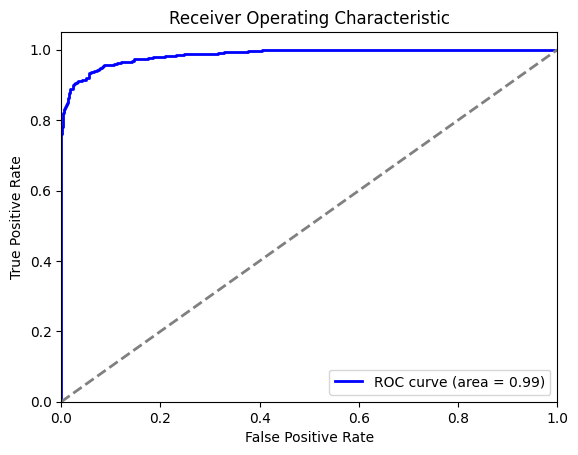

ROC AUC: 0.7377894485557411


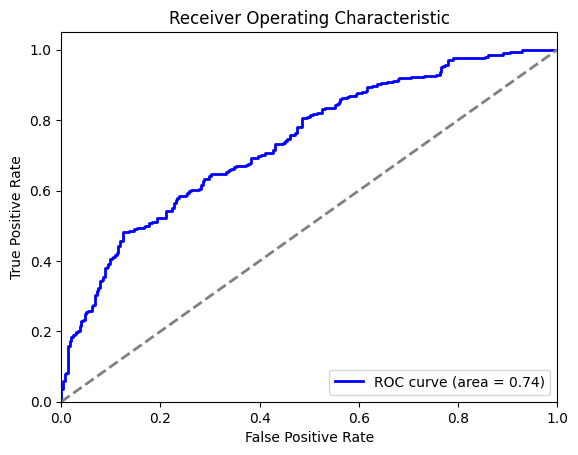

   apply_promo
0         0.16
1         0.79
2         0.83
3         0.54
4         0.64
ROC AUC: 0.997417577091901


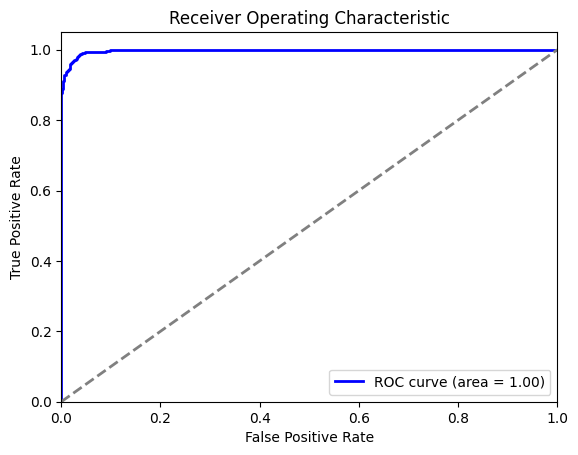

ROC AUC: 0.7108498448317021


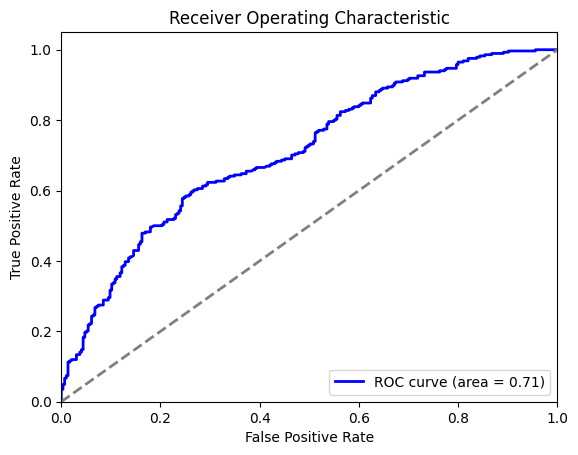

   apply_promo
0         0.20
1         0.79
2         0.77
3         0.49
4         0.69
ROC AUC: 0.9921800357246708


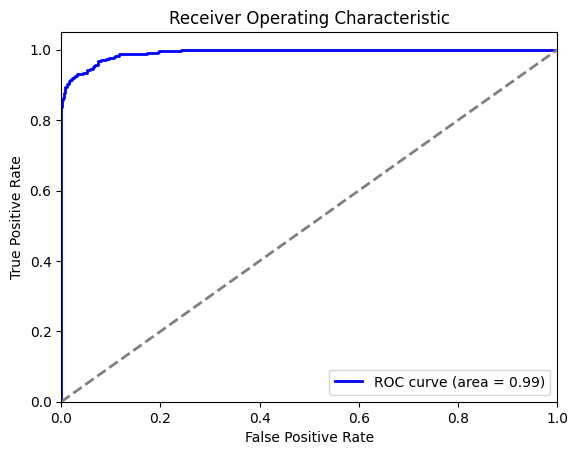

ROC AUC: 0.715546669849606


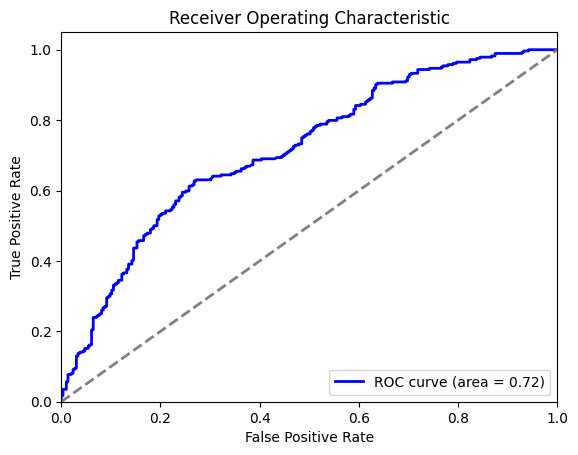

   apply_promo
0         0.18
1         0.79
2         0.84
3         0.70
4         0.78
ROC AUC: 0.9987070576994974


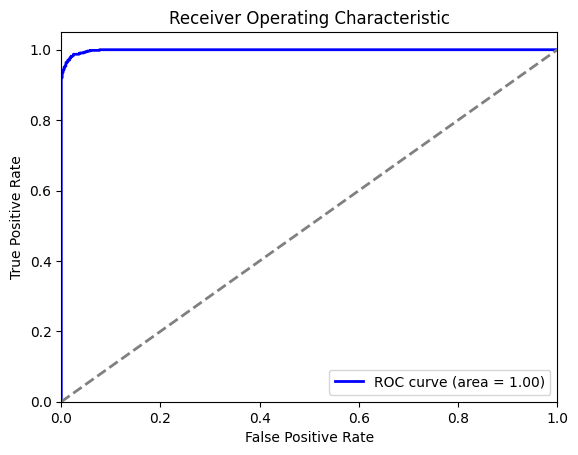

ROC AUC: 0.7125686321317737


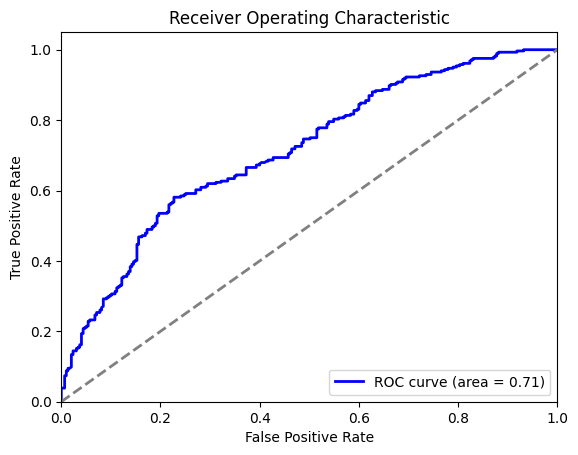

   apply_promo
0         0.21
1         0.76
2         0.65
3         0.40
4         0.70
ROC AUC: 0.9689797698666556


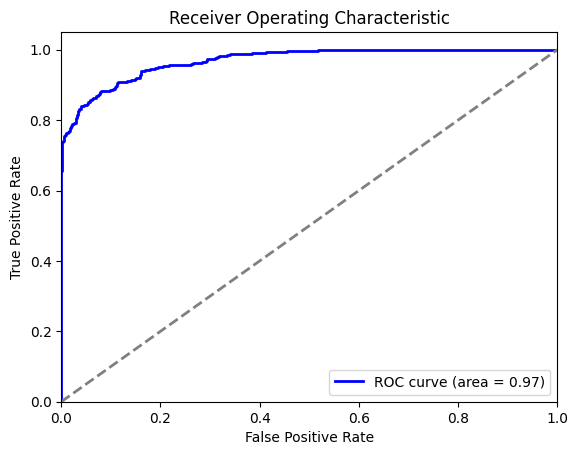

ROC AUC: 0.7297744091668656


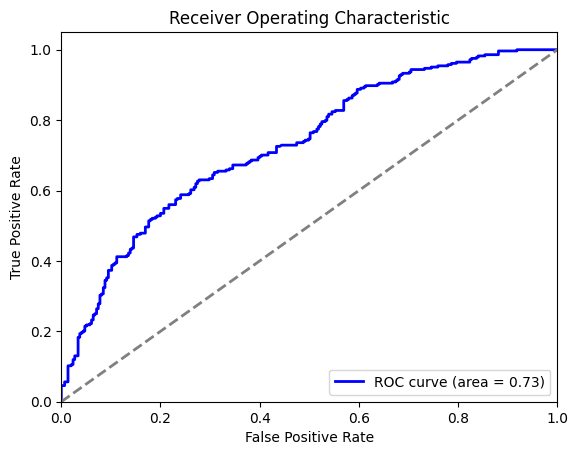

In [ ]:
the_best_params = [{'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 197},
                   {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 55},
                   {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 63},
                   {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 63},
                   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200},
                   {'bootstrap': True, 'max_depth': None, 'min_samples_split': 5},
                   {'bootstrap': False, 'max_depth': None, 'min_samples_split': 5},
                   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}]



rf_models = dict()
for i, params in enumerate(the_best_params):
  rf_model = RandomForestClassifier(**params, random_state=42)

  # Обучение модели
  rf_model.fit(X_train, y_train)
  rf_models[i] = {'model': rf_model, 'params': params, 'roc_auc': roc_auc_score(y_val, rf_model.predict_proba(X_val)[:, 1])}
  create_predictions(rf_model, X_test, save_name=f'rf_model_with_under_sampling_test_{i}')
  create_roc_auc_curve(rf_model, X_train, y_train)
  create_roc_auc_curve(rf_model, X_val, y_val)




In [ ]:
rf_0 = pd.read_csv('/content/rf_model_with_under_sampling_0.csv')
rf_1 = pd.read_csv('/content/rf_model_with_under_sampling_1.csv')
rf_2 = pd.read_csv('/content/rf_model_with_under_sampling_2.csv')
rf_3 = pd.read_csv('/content/rf_model_with_under_sampling_3.csv')
rf_4 = pd.read_csv('/content/rf_model_with_under_sampling_4.csv')

mean_rf_pred = (rf_0 + rf_1 + rf_2 + rf_3 + rf_4) / 5
mean_rf_pred.to_csv(f'mean_rf_pred_v1.csv', index_label='index')

In [ ]:
class_weights, np.unique(y_train)

(array([ 0.51536375, 16.77206771]), array([0, 1]))

ROC AUC: 0.9998428565059465


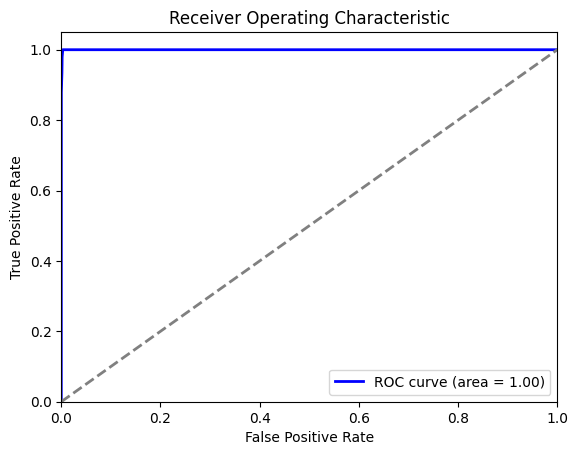

ROC AUC: 0.7939380548100743


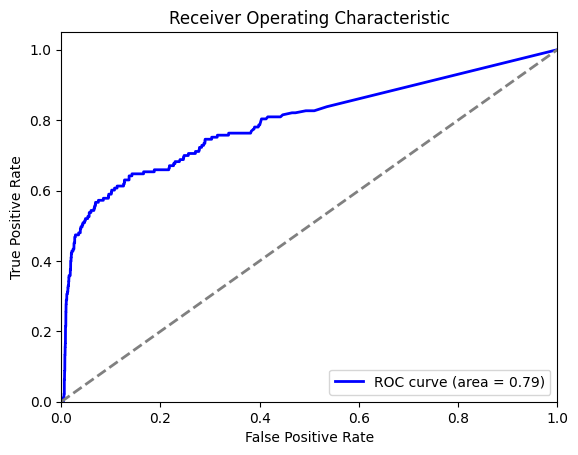

In [ ]:
create_roc_auc_curve(best_model, X_train, y_train)  # Если обучаем на x_train_main и y_train_main
create_roc_auc_curve(best_model, X_val, y_val)  # То можно не рисовать график, а сразу записывать ответы

In [ ]:
X_val.head()

13497    0
13741    0
23588    0
13909    0
26136    0
Name: apply_promo, dtype: int64

In [ ]:
X_val.shape, y_val.shape

((5549, 12), (5549,))

In [ ]:
predictions = create_predictions(rf_model_gs, X_test, save_name='predictions_rf_grid_search_with_balanced_classes_v1')
# pred_last = pd.read_csv('/content/predictions_rf_grid_search.csv')

   apply_promo
0         0.13
1         0.62
2         0.48
3         0.32
4         0.33


In [ ]:
# predictions.shape, pred_last.shape

In [ ]:
rf_model_gs.predict_proba(X_test).shape, X_test.shape

((6806, 2), (6806, 12))

In [ ]:
# predictions.head(), pred_last.head()

## Lazy predict

In [ ]:
!pip install lazypredict

In [56]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_val, y_train, y_val)
models

100%|██████████| 29/29 [00:02<00:00, 10.02it/s]

[LightGBM] [Info] Number of positive: 543, number of negative: 532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 1075, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505116 -> initscore=0.020466
[LightGBM] [Info] Start training from score 0.020466


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.68,0.67,0.67,0.67,0.12
CalibratedClassifierCV,0.68,0.67,0.67,0.67,0.31
LogisticRegression,0.68,0.67,0.67,0.67,0.03
RidgeClassifier,0.67,0.67,0.67,0.67,0.03
LinearDiscriminantAnalysis,0.67,0.67,0.67,0.67,0.05
RidgeClassifierCV,0.67,0.67,0.67,0.67,0.03
LinearSVC,0.67,0.67,0.67,0.67,0.13
GaussianNB,0.66,0.66,0.66,0.66,0.02
AdaBoostClassifier,0.66,0.66,0.66,0.66,0.20


## Logistic Regression

In [54]:
# Обучение модели (например, логистическая регрессия)
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

ROC AUC: 0.6361189576150321


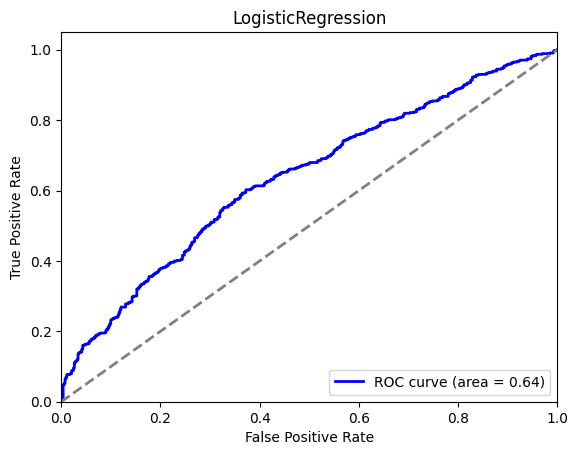

ROC AUC: 0.6517665313917403


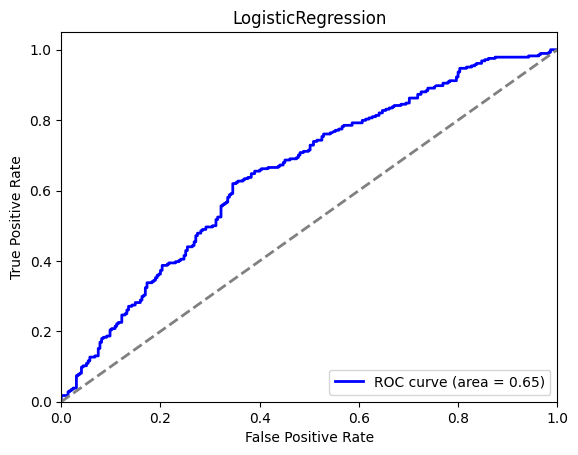

   apply_promo
0         1.00
1         1.00
2         1.00
3         1.00
4         1.00


,apply_promo
0,1.00
1,1.00
2,1.00
3,1.00
4,1.00
...,...
6801,1.00
6802,1.00
6803,1.00
6804,1.00


In [55]:
create_roc_auc_curve(lg, X_train, y_train)
create_roc_auc_curve(lg, X_val, y_val)

create_predictions(lg, X_test, save_name='predictions_lg_v1')

## GaussianNB with GridSearchCV

In [ ]:

from sklearn.model_selection import GridSearchCV

# Создание модели GaussianNB
gaussian = GaussianNB()

# Создание 100 значений var_smoothing в логарифмической шкале
# Используем логарифмическое распределение от 1e-10 до 1e-2
log_min = np.log10(1e-10)
log_max = np.log10(1e-2)
log_values = np.linspace(log_min, log_max, 100)
var_smoothing_values = 10 ** log_values

# Параметры для GridSearchCV
param_grid = {
    'var_smoothing': var_smoothing_values # пример значений для подбора
}

# Настройка GridSearchCV
gs_gaussian = GridSearchCV(estimator=gaussian, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Обучение GridSearchCV
gs_gaussian.fit(X_train, y_train)

# Печать лучших параметров
print("Best parameters found: ", gs_gaussian.best_params_)

# Лучшая модель
best_model_gauss = gs_gaussian.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'var_smoothing': 9.999999999999999e-11}


ROC AUC: 0.6932894119591558


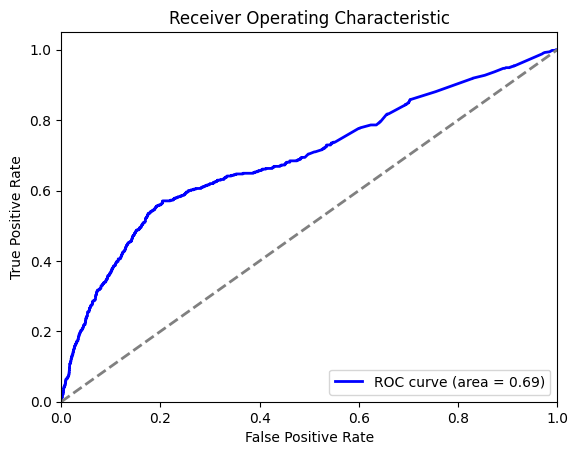

ROC AUC: 0.6932894119591558


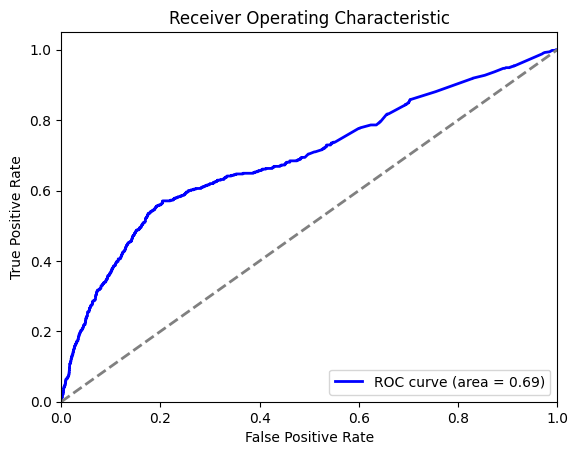

In [ ]:
create_roc_auc_curve(best_model_gauss, X_train, y_train)
create_roc_auc_curve(best_model_gauss, X_val, y_val)

In [ ]:
create_predictions(best_model_gauss, X_test, save_name='predictions_gauss_with_grid_search')

   apply_promo
0         0.01
1         0.93
2         0.00
3         0.00
4         0.05


## Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.extmath import softmax
from sklearn.metrics.pairwise import pairwise_distances


class MyNearestCentroid(NearestCentroid):
  def predict_proba(self, X):
    distances = pairwise_distances(X, self.centroids_, metric=self.metric)
    probs = softmax(distances)
    return probs


# Создание модели NearestCentroid
nearest_centroid = MyNearestCentroid()

# Обучение модели
nearest_centroid.fit(X_train, y_train)

# Получение расстояний до ближайших центроидов
nearest_centroid.predict_proba(X_val)

# Преобразование расстояний в псевдовероятности
# scaler = MinMaxScaler()
# probabilities = scaler.fit_transform(distances.reshape(-1, 1))

NameError: name 'X_val' is not defined

In [ ]:
create_roc_auc_curve(nearest_centroid, X_train, y_train)
create_roc_auc_curve(nearest_centroid, X_val, y_val)

In [ ]:
create_predictions(nearest_centroid, X_test, save_name='predictions_my_nearest_centroid')

## Random Forest Classificator

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Создание и обучение модели RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
create_roc_auc_curve(rf, X_train, y_train)
create_roc_auc_curve(rf, X_val, y_val)

In [ ]:
create_predictions(rf, X_test, save_name='predictions_rf')

# Ensemble the best linear models

   apply_promo
0         0.62
1         0.59
2         0.45
3         0.46
4         0.62
Number 0
ROC AUC: 0.8730164499646906


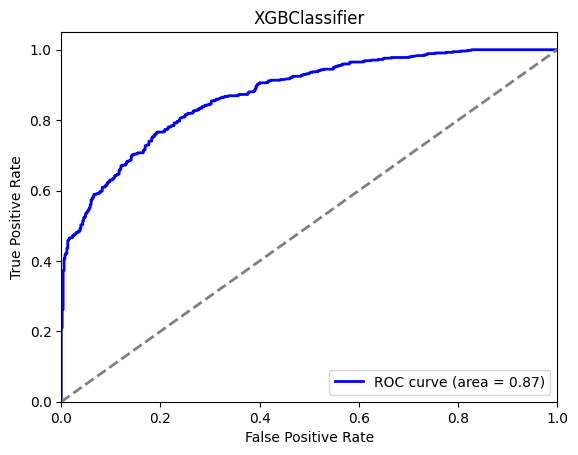

ROC AUC: 0.7123537837192647


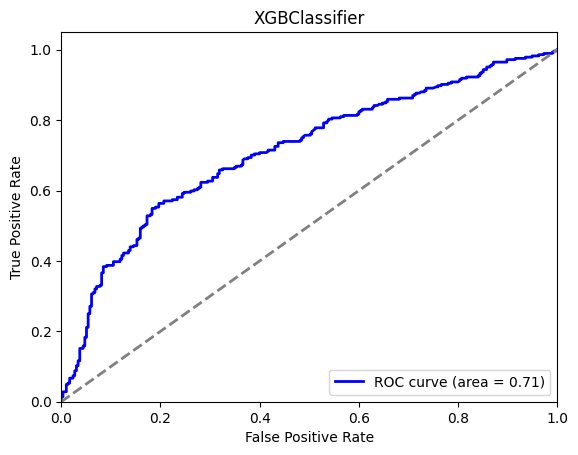

   apply_promo
0         0.72
1         0.55
2         0.33
3         0.33
4         0.72
Number 1
ROC AUC: 0.8272597931292318


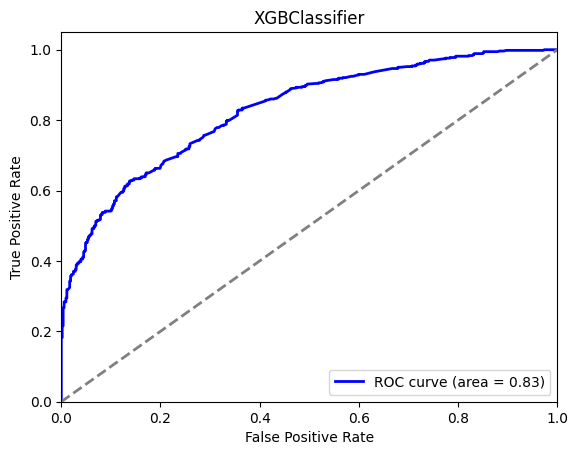

ROC AUC: 0.7153377894485557


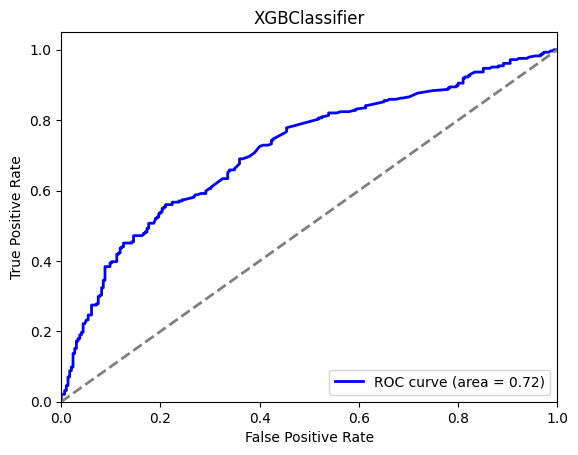

   apply_promo
0         0.00
1         1.00
2         0.00
3         0.00
4         0.00
Number 2
ROC AUC: 0.6786354698901951


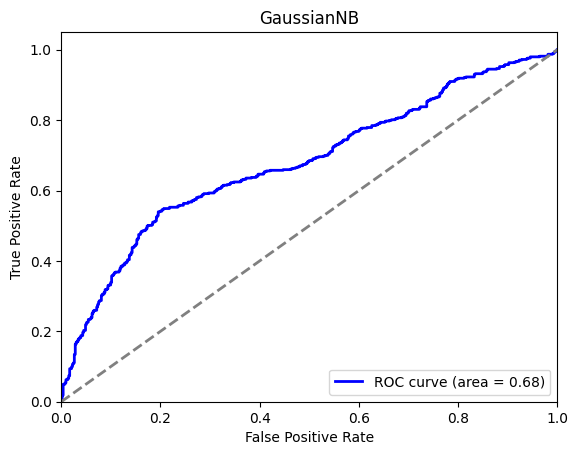

ROC AUC: 0.6783957985199331


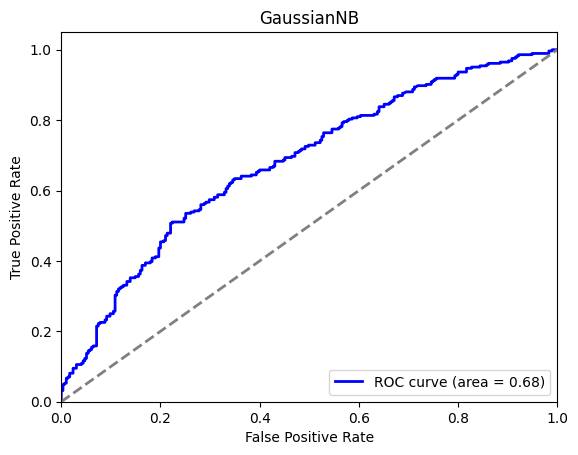

   apply_promo
0         1.00
1         1.00
2         1.00
3         1.00
4         1.00
Number 3
ROC AUC: 0.6361189576150321


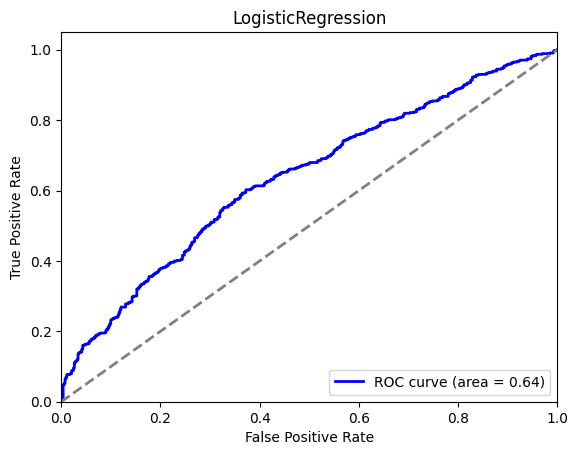

ROC AUC: 0.6517665313917403


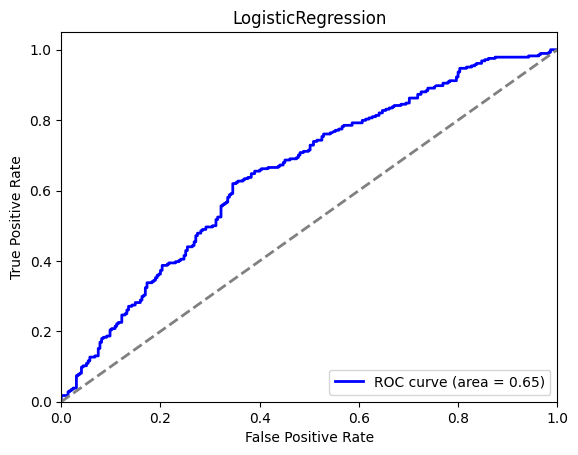

   apply_promo
0         0.51
1         0.59
2         0.47
3         0.43
4         0.51
Number 4
ROC AUC: 0.8476543568866919


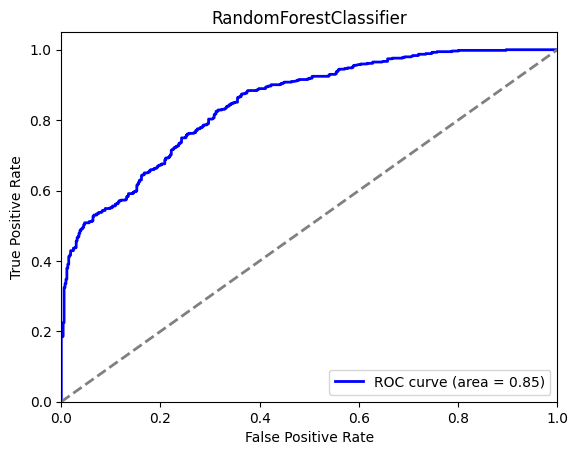

ROC AUC: 0.7116734304129864


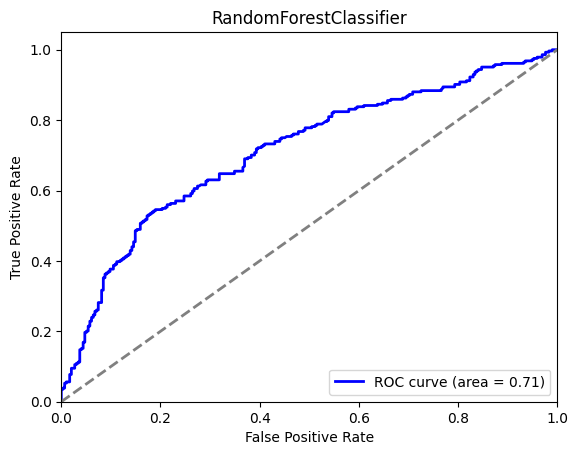

   apply_promo
0         0.48
1         0.46
2         0.54
3         0.55
4         0.48
Number 5
ROC AUC: 0.9100098312078538


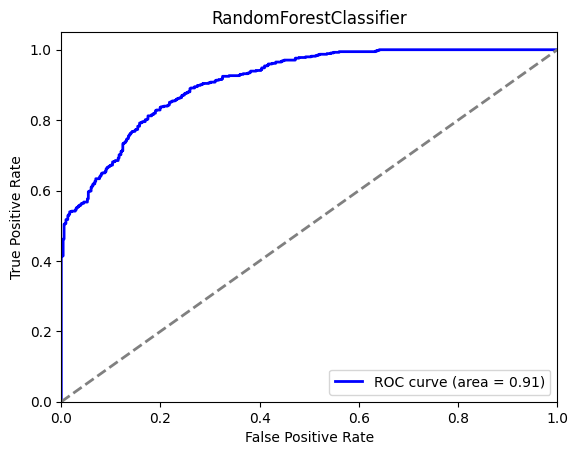

ROC AUC: 0.7137085223203629


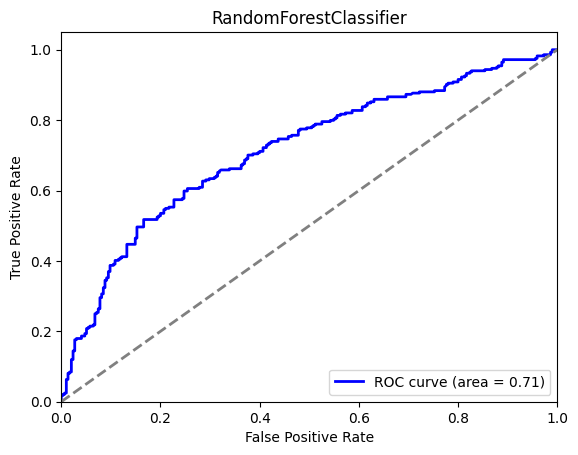

   apply_promo
0         0.48
1         0.46
2         0.54
3         0.55
4         0.48
Number 6
ROC AUC: 0.9100098312078538


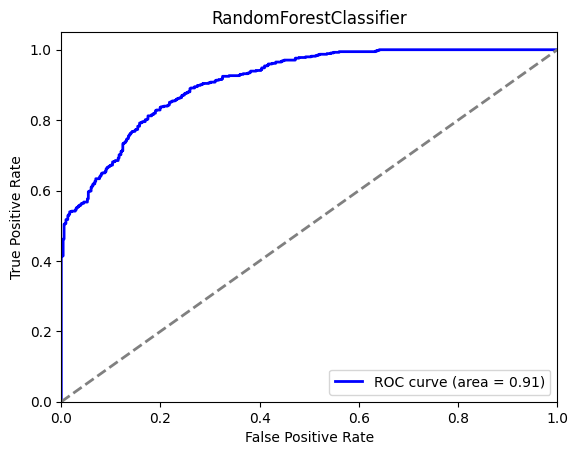

ROC AUC: 0.7137085223203629


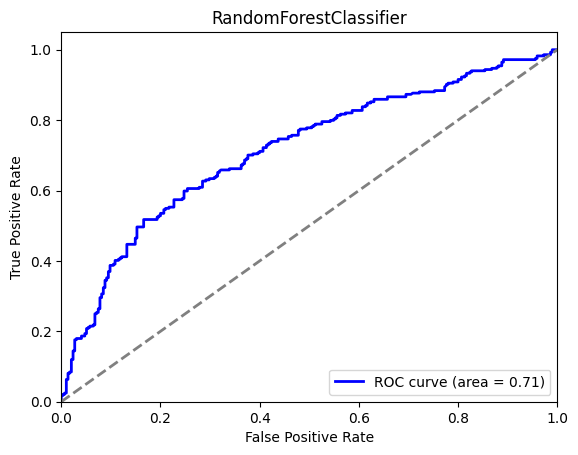

   apply_promo
0         0.51
1         0.49
2         0.52
3         0.49
4         0.51
Number 7
ROC AUC: 0.8233982746922555


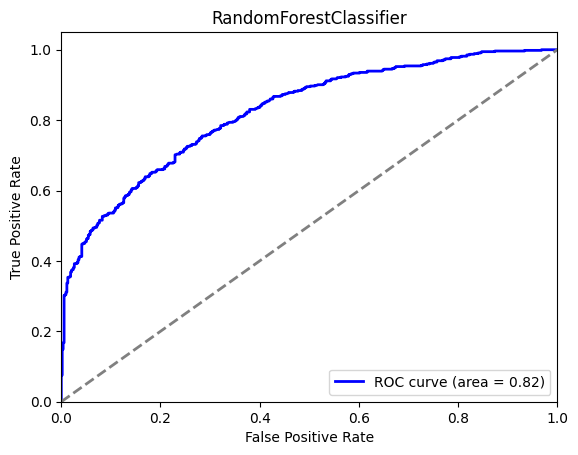

ROC AUC: 0.7169491525423729


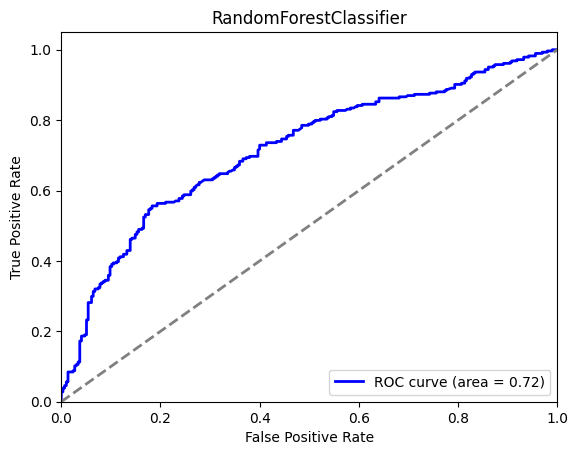

   apply_promo
0         0.49
1         0.53
2         0.58
3         0.51
4         0.49
Number 8
ROC AUC: 0.9246337528905134


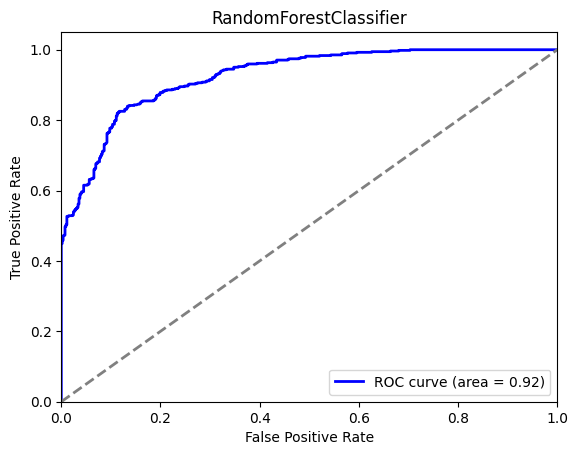

ROC AUC: 0.7117271425161137


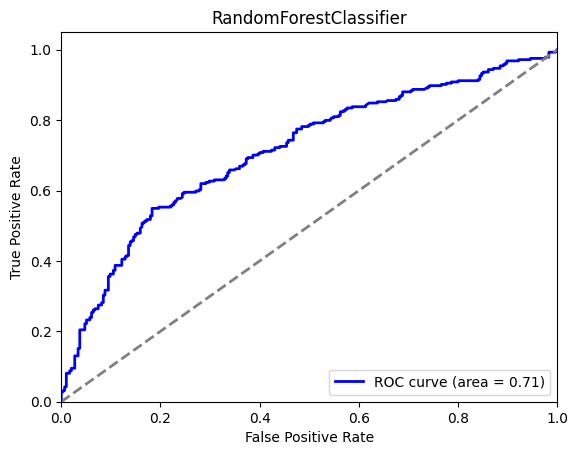

   apply_promo
0         0.54
1         0.55
2         0.48
3         0.44
4         0.54
Number 9
ROC AUC: 0.8450702031321398


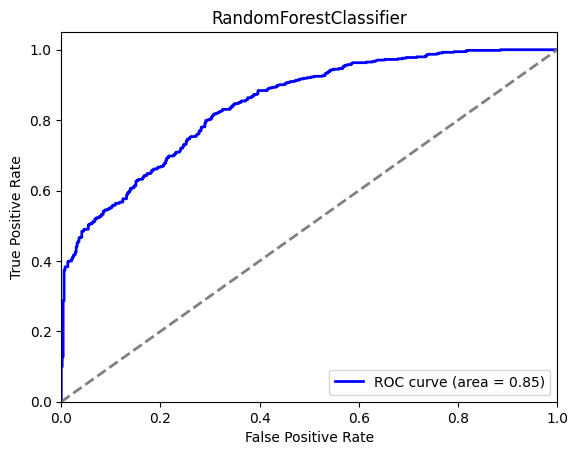

ROC AUC: 0.7107662926712819


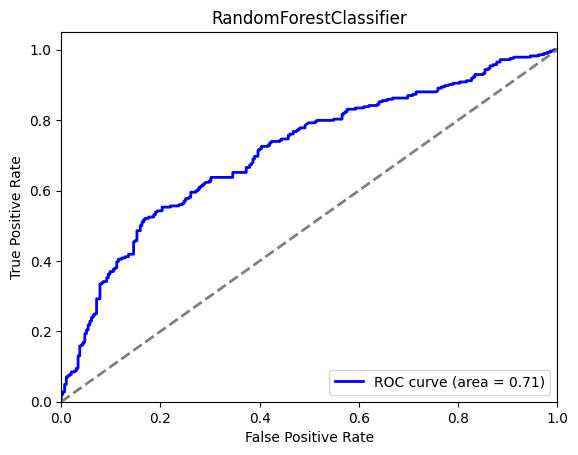

In [50]:
grid_xgb_params = {'alpha': 0.3,
              'colsample_bytree': 0.7, 'gamma': 0.1,
              'lambda': 0.1, 'learning_rate': 0.01,
              'max_depth': 5, 'min_child_weight': 1,
              'n_estimators': 100, 'subsample': 0.7}

optuna_xgb_params = {'n_estimators': 30, 'learning_rate': 0.131,
                     'max_depth': 3, 'min_child_weight': 1,
                     'subsample': 0.987, 'colsample_bytree': 0.915}

gauss_params = {'var_smoothing': 2e-5}

rf_models_params = [
    {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 81},  # Самостоятельно ~66%
    {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100},
    {'bootstrap': True, 'class_weight': None, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100},  # Самостоятельно ~64%
    {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 63},
    {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 75}
    ]


grid_xgb_model = xgb.XGBClassifier(**grid_xgb_params, random_state=42)
optuna_xgb_model = xgb.XGBClassifier(**optuna_xgb_params, random_state=42)
gauss_model = gaussian = GaussianNB(**gauss_params)
lg = LogisticRegression(random_state=42)
rf_models = [RandomForestClassifier(**param, random_state=42) for param in rf_models_params]
models = [grid_xgb_model, optuna_xgb_model, gauss_model, lg] + rf_models


models_result = dict()
for i, model in enumerate(models):
  model.fit(X_train, y_train)
  models_result[i] = {'model': model, 'roc_auc': roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])}

  create_predictions(model, X_test, save_name=f'ensemble_wth_und_sampl_{i}')
  print(f'Number {i}')
  create_roc_auc_curve(model, X_train, y_train)
  create_roc_auc_curve(model, X_val, y_val)

In [53]:
csv = [pd.read_csv(f'/content/ensemble_wth_und_sampl_{i}.csv') for i in range(0, len(models))]
mean_result_best_models = sum(csv) / len(csv)
mean_result_best_models.to_csv(f'mean_result_best_models_v7.csv', index_label='index')

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Пробуем создать фичи заново

#### Гипотезы

Гипотеза: Если не видоизменить скидку процентная скидка идет в свой столбец, а рублевая или в коинах в другой столбец, то будут недопонимания у модели.
Так как модель числа 25 и 200 считает в одних и тех же рублях (так как 200% многовато будет), а 25% бывает намного лучше 200 рублей или коинов
-> Сделал money_discount и percent_discount

Гипотеза: Если заказ отменили, то лучше его отбросить при обучении, так как он может ухудшать качество обучения.
Разбираюсь в отмененных заказах (OrderState с 4 или с 11 отменен?).


Гипотеза: А влияет ли какая платформа у пользователя? Ну то есть ios -> значит больше платит, а android значит меньше - это логично, но вот на использование промокодов, тоже нужно будет глянуть


In [28]:
# Чистим train and test
train_df = train_df.drop(['LocalBeginDate', 'LocalEndDate'], axis=1)
train_df['OrderType'] = train_df['OrderType'].map({'1,2,3': 1, '2,3': 0})
train_df = train_df.rename(columns={'Discount': 'money_discount'})
train_df['percent_discount'] = train_df['money_discount']
train_df.loc[train_df['Id'] == 6, 'money_discount'] = 0
train_df.loc[train_df['Id'] != 6, 'percent_discount'] = 0



test_df = test_df.drop(['LocalBeginDate', 'LocalEndDate'], axis=1)
test_df['OrderType'] = test_df['OrderType'].map({'1,2,3': 1, '2,3': 0})
test_df = test_df.rename(columns={'Discount': 'money_discount'})
test_df['percent_discount'] = test_df['money_discount']
test_df.loc[test_df['Id'] == 6, 'money_discount'] = 0
test_df.loc[test_df['Id'] != 6, 'percent_discount'] = 0

In [29]:
train_df.head()

,ClientUUId,Id,OrderType,OrderPrice,money_discount,apply_promo,percent_discount
0,000D3A20F23EA95811E7B99F3ED09FC8,7,0,699,200,0,0
1,000D3A20F23EA95811E7B99F3ED09FC8,6,1,1249,0,0,25
2,000D3A20F23EA95811E7BD373E79565E,5,0,799,200,0,0
3,000D3A20F23EA95811E7BD373E79565E,5,1,1249,250,0,0
4,000D3A20F23EA95811E7BDAE71CD3F33,6,0,699,0,0,30


Теперь можно делать например фичи средняя скидка на пользователя, и т.п.

In [33]:
orders_columns = ['OrderUUId', 'ClientUUId',  # 'Date', 'SaleDate', # 'OrderState',
                  'NewClient', 'ClientOrderNumber',
                  'ProductTotalPrice','MenuPrice', 'Discount',
                  'OrderTotalPrice', 'OrderType', 'apply_promo']


# Данная скидка будет в рублях
order_total_price = orders.groupby('OrderUUId')['OrderTotalPrice'].max()
menu_total_price = orders.groupby('OrderUUId')['MenuPrice'].sum()
discount = pd.DataFrame({'Discount': menu_total_price - order_total_price})

orders = pd.merge(orders, discount, on='OrderUUId', how='left')

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo,Discount
0,020DD76CCD949AE011EDE031ED5D76FD,NaN,NaN,000D3AAC9DCABB2E11EBE0614C89D044,2023-04-21,2023-04-21T20:51:26.000Z,000D3A2480C380DA11E692CFB9F92484,0,18,000D3A240C71BE9A11E719BE2AB264A6,4,1.00,45.00,4,2,1.00,3,0,44.00
1,02164D9B0F67BC3311EE610987AF48C7,0.00,0.00,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EC9AABAD354BE051CCF1EE1F83A8D0,1,485.00,485.00,4,2,1164.00,1,0,0.00
2,02164D9B0F67BC3311EE610987AF48C7,0.00,0.00,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EB846583CB3BDEA80D1A7F2E184D40,1,589.00,589.00,4,2,1164.00,1,0,0.00
3,02164D9B0F67BC3311EE610987AF48C7,0.00,0.00,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB267FD,4,45.00,45.00,4,2,1164.00,1,0,0.00
4,02164D9B0F67BC3311EE610987AF48C7,0.00,0.00,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB264A6,4,45.00,45.00,4,2,1164.00,1,0,0.00


In [39]:
orders['MaxDiscount'] = orders['Discount'].groupby(orders['ClientUUId']).transform('max')
orders['MinDiscount'] = orders['Discount'].groupby(orders['ClientUUId']).transform('min')
orders['AvgDiscount'] = orders['Discount'].groupby(orders['ClientUUId']).transform('mean')
orders['TotalDiscount'] = orders['Discount'].groupby(orders['ClientUUId']).transform('sum')

orders['OrdersWithDiscount'] = (orders['Discount'] > 0).astype(int).groupby(orders['ClientUUId']).transform('sum')
orders['DiscountPerOrder'] = orders['Discount'] / orders['OrderTotalPrice']
avg_discount_per_order = orders.groupby('ClientUUId')['DiscountPerOrder'].mean().reset_index(name='AvgDiscountPerOrder')
median_discount_per_order = orders.groupby('ClientUUId')['DiscountPerOrder'].median().reset_index(name='MedianDiscountPerOrder')
max_discount_per_order = orders.groupby('ClientUUId')['DiscountPerOrder'].max().reset_index(name='MaxDiscountPerOrder')
std_discount_per_order = orders.groupby('ClientUUId')['DiscountPerOrder'].std().reset_index(name='StdDiscountPerOrder')

Разбираюсь в отмененных заказах (OrderState с 4 или с 11 отменен?). Гипотеза: Если заказ отменили, то лучше его отбросить при обучении, так как он может ухудшать качество обучения

In [12]:
# Статус "4" и применил промокод
orders[(orders['OrderState'] == 4) & (orders['apply_promo'] == 1)].shape

(113379, 18)

In [11]:
# Статус "4" не применил промокод
orders[(orders['OrderState'] == 4) & (orders['apply_promo'] == 0)].shape

(490032, 18)

In [13]:
# Статус "11" применил промокод
orders[(orders['OrderState'] == 11) & (orders['apply_promo'] == 1)].shape

(1436, 18)

In [14]:
# Статус "11" не применил промокод
orders[(orders['OrderState'] == 11) & (orders['apply_promo'] == 0)].shape

(6892, 18)

Гипотеза: А влияет ли какая платформа у пользователя? Ну то есть ios -> значит больше платит, а android значит меньше - это логично, но вот на использование промокодов, тоже нужно будет глянуть